In [12]:
from scipy.optimize import curve_fit
def hyptan(x, g, d, rho0):
    return 0.5 * rho0 * (1 - np.tanh(2 * (x - g) / d))

def fit_interface_single_frame(z_pos, sigma=1.0, dz=0.1):
    z_min = np.floor(z_pos.min()) - 5
    z_max = np.ceil(z_pos.max()) + 5
    z_grid = np.arange(z_min, z_max, dz)
    density = np.zeros_like(z_grid)
    for zi in z_pos:
        density += np.exp(-(z_grid - zi) ** 2 / (2 * sigma ** 2))
    density *= 1 / (np.sqrt(2 * np.pi) * sigma)
    half_max = density.max() / 2
    mask_half = density > half_max
    z_half_min = z_grid[mask_half].min()
    z_half_max = z_grid[mask_half].max()
    z_mid = 0.5 * (z_half_min + z_half_max)
    rho0 = density[(z_grid > z_half_min + 2) & (z_grid < z_half_max - 2)].mean()
    popt1, _ = curve_fit(lambda x, g, d: hyptan(x, g, d, rho0),
                         z_grid[z_grid > z_mid], density[z_grid > z_mid], p0=[z_half_max, 1.0])
    z_interface1, _ = popt1
    popt0, _ = curve_fit(lambda x, g, d: hyptan(-x, g, d, rho0),
                         z_grid[z_grid < z_mid], density[z_grid < z_mid], p0=[-z_half_min, 1.0])
    z_interface0, _ = -popt0[0], popt0[1]
    return z_interface0,z_interface1

def calc_interface(pos, water_indices):
    z_water = pos[water_indices][:, 2]
    z_interface0,z_interface1 = fit_interface_single_frame(z_water) # unit Å
    return z_interface0*10,z_interface1*10


In [13]:
import numpy as np
import freud
import mdtraj as md
from collections import defaultdict
pdb = "water-PE.pdb"
dcd="water-PE.dcd"
traj = md.load(dcd, top=pdb)
top = traj.topology
#traj[1000:1100].save_dcd('water-PE.dcd')

In [14]:
def compute_angle(v1, v2):
    cos_theta = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def count_hbonds_for_ox_old(wrapped, ox_idx, oh2_map, h_indices, cutoff_dist=2.7, angle_thresh=115):
    pos = wrapped.xyz[0] * 10  # nm → Å
    ox_pos = pos[ox_idx]
    count = 0
    for h_idx in h_indices:
        h_atom = wrapped.topology.atom(h_idx)
        h_pos = pos[h_idx]
        dist = np.linalg.norm(h_pos - ox_pos)
        if dist < cutoff_dist:
            res_idx = h_atom.residue.index
            if res_idx not in oh2_map:
                continue
            oh2_pos = pos[oh2_map[res_idx]]
            angle = compute_angle(ox_pos - h_pos, oh2_pos - h_pos)
            if angle > angle_thresh:
                count += 1
    return count
def count_hbonds_for_ox(wrapped, ox_idx, h_indices, cutoff_dist=2.7, angle_thresh=115):
    
    pos = wrapped.xyz[0] * 10  # nm → Å
    ox_pos = pos[ox_idx]
    count = 0

    for h_idx in h_indices:
        h_pos = pos[h_idx]
        dist = np.linalg.norm(h_pos - ox_pos)

        if dist < 1.2:
            continue

        if dist < cutoff_dist:
           
            dists_to_all_O = np.linalg.norm(pos[O_indices] - h_pos, axis=1)
            nearest_O_idx = O_indices[np.argmin(dists_to_all_O)]
            if nearest_O_idx == ox_idx:
                continue  

            oh2_pos = pos[nearest_O_idx]
            angle = compute_angle(ox_pos - h_pos, oh2_pos - h_pos)
            if angle > angle_thresh:
                count += 1
    return count

/var/folders/40/0fthn81568n22s317pxyvyfh0000gn/T/ipykernel_65110/1580037554.py:18: RuntimeWarning: Mean of empty slice.
  rho0 = density[(z_grid > z_half_min + 2) & (z_grid < z_half_max - 2)].mean()
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/40/0fthn81568n22s317pxyvyfh0000gn/T/ipykernel_65110/1580037554.py:19: OptimizeWarning: Covariance of the parameters could not be estimated
  popt1, _ = curve_fit(lambda x, g, d: hyptan(x, g, d, rho0),
/var/folders/40/0fthn81568n22s317pxyvyfh0000gn/T/ipykernel_65110/1580037554.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  popt0, _ = curve_fit(lambda x, g, d: hyptan(-x, g, d, rho0),


Frame 0: found 4 OH⁻, hbond counts = [(14.647718429565089, 4), (16.424482345581257, 5), (15.37088203430196, 4), (17.755285263061726, 4)]
Frame 1: found 4 OH⁻, hbond counts = [(14.388442993163721, 5), (17.66925621032735, 5), (15.48636054992696, 4), (17.83976173400899, 4)]
Frame 2: found 4 OH⁻, hbond counts = [(14.249183654784815, 5), (17.44701194763204, 5), (15.853511810302937, 5), (17.891309738159382, 4)]
Frame 3: found 4 OH⁻, hbond counts = [(15.110439300536768, 5), (17.411058425903523, 5), (16.10685157775899, 5), (17.17634963989278, 4)]
Frame 4: found 4 OH⁻, hbond counts = [(14.91699981689419, 5), (17.61100006103536, 5), (16.087301254272663, 5), (17.58330345153829, 4)]
Frame 5: found 4 OH⁻, hbond counts = [(13.762100219726221, 5), (17.876501083374226, 4), (16.29070091247579, 4), (16.99379920959493, 4)]
Frame 6: found 4 OH⁻, hbond counts = [(14.495574951171534, 5), (18.35562896728536, 4), (16.486833572387898, 5), (17.597530364990437, 4)]
Frame 7: found 4 OH⁻, hbond counts = [(14.76477

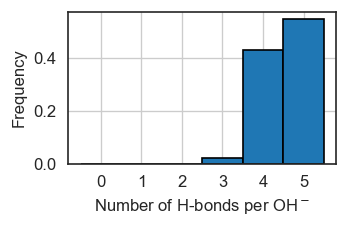

In [26]:
import mdtraj as md
import numpy as np
import freud
import matplotlib.pyplot as plt
import os
O_indices = [a.index for a in top.atoms if a.name in ['OH2', 'OX']]
H_indices = [a.index for a in top.atoms if a.name in ['H1', 'H2', 'HX']]
X_indices = [a.index for a in top.atoms if a.name == 'X']
oh2_map = {atom.residue.index: atom.index for atom in top.atoms if atom.name in ["O", "OX","OH2"]}


def detect_ohminus_and_count_hbonds(dcd_file, top_file, stride=1):
    traj = md.load(dcd_file, top=top_file)
    top = traj.topology

 

    all_counts = []
    #frame_ox_hbond_records =[]
    for it in range(0, traj.n_frames, stride):
    #for it in range(10, 1800, stride):
        frame = traj[it]
        box_lengths = frame.unitcell_lengths[0] * 10  
        fbox = freud.box.Box.from_box(box_lengths)   
        xyz = frame.xyz[0]*10  # shape: (n_atoms, 3)

        Opos = xyz[O_indices]
        Hpos = xyz[H_indices]
        Xpos = xyz[X_indices]

        aq_H = freud.locality.AABBQuery(fbox, Hpos)
        nlist = aq_H.query(Opos, {'r_max': 1.25}).toNeighborList()
        un, co = np.unique(nlist.query_point_indices, return_counts=True)

        OH_idx_local = un[np.where(co == 1)]

        OHm_local_indices = []
        if len(OH_idx_local) > 0 and len(X_indices) > 0:
            OH_pos_array = Opos[OH_idx_local]
            aq_X = freud.locality.AABBQuery(fbox, Xpos)
            nlist_x = aq_X.query(OH_pos_array, {'r_max': 0.7}).toNeighborList()
            unx, cox = np.unique(nlist_x.query_point_indices, return_counts=True)

            OHm_local_indices = [OH_idx_local[i] for i in np.where(cox>2)[0]]
            if len(OHm_local_indices)<5:
                for loc_idx in OHm_local_indices:
                    ox_idx = O_indices[loc_idx]
                    anchor_atoms = set(top.atom(ox_idx).residue.atoms)
                    wrapped = frame.image_molecules(anchor_molecules=[anchor_atoms])
                    #count = count_hbonds_for_ox(wrapped, ox_idx, oh2_map, H_indices)
                    count = count_hbonds_for_ox(wrapped, ox_idx, H_indices)
                    o_global = ox_idx       #   global index of this O
                    z_interface0,z_interface1 = calc_interface(frame.xyz[0], O_indices)
                    dz0 = float(xyz[o_global][2] - z_interface0)
                    dz1 = float(z_interface1-xyz[o_global][2])
                    dz = min(dz0, dz1)
                    all_counts.append((dz, count))
                print(f"Frame {it}: found {len(OHm_local_indices)} OH⁻, hbond counts = {all_counts[-len(OHm_local_indices):]}")
                    
            else:
                tmp_counts=[]
                
                for loc_idx in OHm_local_indices:
                    ox_idx = O_indices[loc_idx]
                    anchor_atoms = set(top.atom(ox_idx).residue.atoms)
                    wrapped = frame.image_molecules(anchor_molecules=[anchor_atoms])
                    #count = count_hbonds_for_ox(wrapped, ox_idx, oh2_map, H_indices)
                    count = count_hbonds_for_ox(wrapped, ox_idx, H_indices)

                    o_global = ox_idx       #  global index of this O
                    z_interface0,z_interface1 = calc_interface(frame.xyz[0], O_indices)
                    dz0 = float(xyz[o_global][2] - z_interface0)
                    dz1 = float(z_interface1-xyz[o_global][2])
                    dz = min(dz0, dz1)
                    #print(dz0, dz1)
                    tmp_counts.append((dz, count))
                    #frame_ox_hbond_records.append((it, ox_idx, count))
                top4 = sorted(tmp_counts)[-4:]
                all_counts.extend(top4)
                print(f"Frame {it}: found {len(top4)} OH⁻, hbond counts = {all_counts[-len(top4):]}")

    return all_counts #all_counts

def plot_distribution(counts):
    plt.figure(dpi=120, figsize=(3,2))
    bins = np.arange(0, max(counts)+2) - 0.5
    plt.hist(counts, bins=bins, edgecolor='black', density=True)
    plt.xlabel("Number of H-bonds per OH$^-$")
    plt.ylabel("Frequency")
    plt.xticks(range(max(counts)+1))
    plt.grid(True)
    plt.tight_layout()
    plt.show()



if not os.path.exists(dcd):
    print(f"no {dcd} found")
else:
    counts = detect_ohminus_and_count_hbonds(dcd, pdb, stride=1)
    only_counts = [c[1] for c in counts] 
    plot_distribution(only_counts)

    only_counts = np.array(only_counts)
    


In [24]:
import numpy as np

counts = np.array(counts)  # shape (N, 2)
dz_array = counts[:, 0]
hb_array = counts[:, 1].astype(int)

# 1)only save dz < 10 Å  
mask = dz_array < 10.0
hb_sel = hb_array[mask]

if hb_sel.size == 0:
    raise ValueError("No configurations with dz < 5 Å, please check your data.")

frac_5   = np.mean(hb_sel == 5)
frac_4   = np.mean(hb_sel == 4)
frac_lt4 = np.mean(hb_sel < 4)

fractions = np.array([frac_5, frac_4, frac_lt4])


print("Total samples with dz < 5 Å:", hb_sel.size)
print("5 H-bonds fraction:", frac_5)
print("4 H-bonds fraction:", frac_4)
print("<4 H-bonds fraction:", frac_lt4)


Total samples with dz < 5 Å: 57
5 H-bonds fraction: 0.3684210526315789
4 H-bonds fraction: 0.6140350877192983
<4 H-bonds fraction: 0.017543859649122806


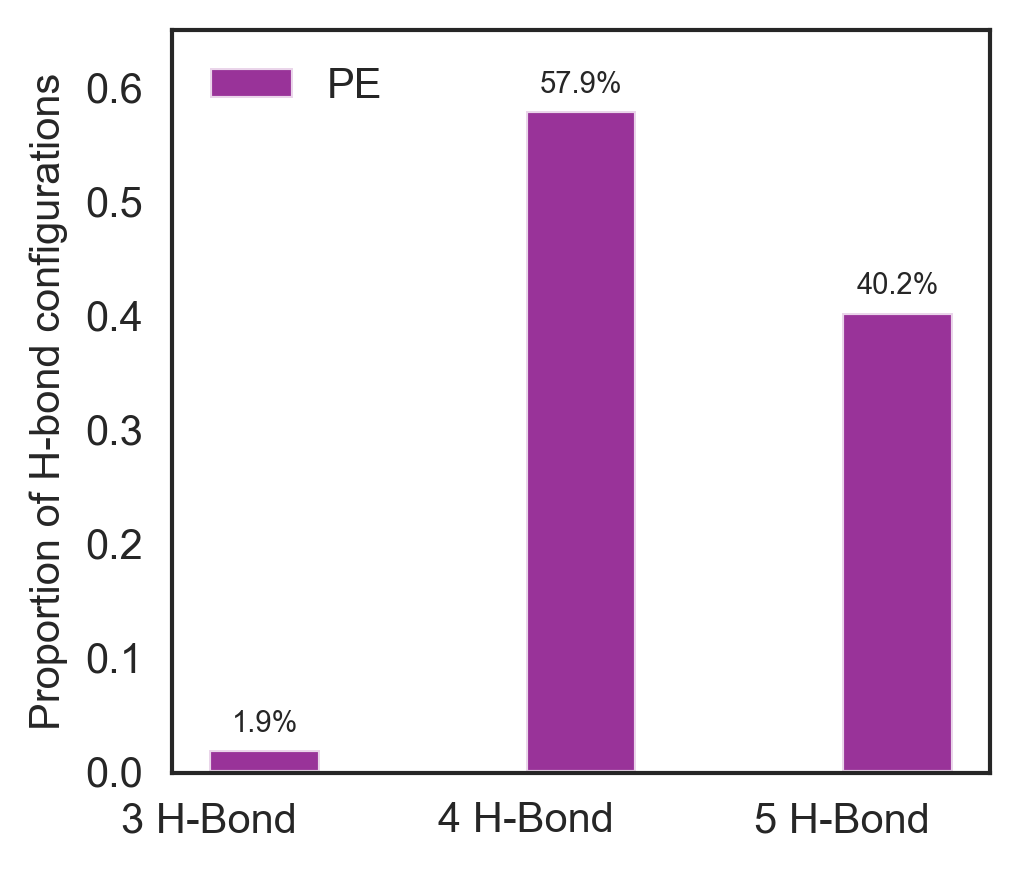

In [25]:
#Probability distribution of OH− hydrogen-bond coordination
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 1
sns.set_style("white") 
fractions = np.array([0.402, 0.579, 0.019])
hb_labels_orig = ["5 H-Bond", "4 H-Bond", "3 H-Bond"]

order = [2, 1, 0] 

ratio_pe = fractions[order]
hb_labels = [hb_labels_orig[i] for i in order]

x = np.arange(len(hb_labels))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)

color_pe = "#FF7F00"   

bars2 = ax.bar(x + bar_width/2, ratio_pe, width=bar_width, label="PE", color="purple", capsize=5, alpha=0.8)

for bars in [bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height*100:.1f}%",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)


ax.set_xticks(x)
ax.set_xticklabels(hb_labels)
ax.set_ylabel("Proportion of H-bond configurations", fontsize=10)
#ax.set_title("Hydrogen Bond Distribution Comparison (3–5 H-Bonds)")
ax.legend(frameon=False, fontsize=10, loc='upper left')
#ax.grid(axis="y", linestyle="--", alpha=0.6)
ax.set_ylim(-0.001, 0.65)
plt.tight_layout()
plt.show()
